In [12]:
from datasets import load_dataset
from transformers import BertModel, BertConfig, BertForSequenceClassification, BertTokenizer
import torch
import torch.nn as nn
import pandas as pd
from tqdm import tqdm
import os

import torch.optim as optim

import matplotlib.pyplot as plt

In [13]:
# load train dataset
train_dataset = load_dataset("glue", "sst2", split="train")

# load validation dataset
val_dataset = load_dataset("glue", "sst2", split="validation")

In [14]:
# setting

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_name = "JeremiahZ/bert-base-uncased-sst2"

tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name, output_hidden_states=True).eval().to(device)
model.eval()

dropout = nn.Dropout(p=0.1).to(device) # in BERT default 0.1

## Custom model

In [31]:
from transformers import BertModel, BertConfig, BertForSequenceClassification
import torch.nn as nn
import torch

class CustomBertSmall(nn.Module):
    def __init__(self, teacher_model, total_layers=6, transplanted_layers=3):
        super().__init__()
        assert transplanted_layers < total_layers, "Transplanted layers must be fewer than total layers"
        
        self.hidden_size = teacher_model.config.hidden_size
        self.total_layers = total_layers
        self.transplanted_layers = transplanted_layers

        # 그대로 복사할 레이어 인덱스 계산
        transplanted_start = 12 - transplanted_layers
        original_layer_indices = list(range(transplanted_start))[:total_layers - transplanted_layers]

        # Embedding 복사
        self.embeddings = teacher_model.bert.embeddings

        # 선택된 layer만 복사해서 재구성
        self.encoder_layers = nn.ModuleList()

        for idx in original_layer_indices:
            layer = teacher_model.bert.encoder.layer[idx]
            self.encoder_layers.append(layer)

        for idx in range(transplanted_start, 12):
            layer = teacher_model.bert.encoder.layer[idx]
            self.encoder_layers.append(layer)

        # Pooler와 Classifier도 복사
        self.pooler = teacher_model.bert.pooler
        self.dropout = teacher_model.dropout  # from classifier head
        self.classifier = teacher_model.classifier

        self.activation = nn.Tanh()  # 여전히 pooler 내부에서도 사용되지만 보존

    # CustomBertSmall에 hidden_states 옵션 추가
    def forward(self, input_ids, attention_mask=None, token_type_ids=None, output_hidden_states=False):
        hidden_states = self.embeddings(input_ids=input_ids, token_type_ids=token_type_ids)

        if attention_mask is not None:
            extended_attention_mask = attention_mask[:, None, None, :]
            extended_attention_mask = (1.0 - extended_attention_mask) * -10000.0
        else:
            extended_attention_mask = None

        all_hidden = []  # 각 레이어 출력 저장
        for layer in self.encoder_layers:
            hidden_states = layer(hidden_states, attention_mask=extended_attention_mask)[0]
            if output_hidden_states:
                all_hidden.append(hidden_states)

        pooled_output = self.pooler(hidden_states)
        pooled_output = self.dropout(self.activation(pooled_output))
        logits = self.classifier(pooled_output)

        if output_hidden_states:
            return logits, all_hidden
        else:
            return logits

## Custom Loss

In [32]:
def train_custom_model(
    model,
    train_dataset,
    val_dataset,
    tokenizer,
    teacher_model=None,  # 👈 custom loss를 쓸 경우 필요
    custom_loss=False,   # 👈 Loss type 선택
    strategy="freeze",
    batch_size=16,
    epochs=10,
    base_lr=5e-5,
    low_lr=5e-6,
    k=3,
    alpha=0.3,           # 👈 custom loss 비중
    unfreeze_epoch=1,
    save_path="best_model.pt",
    device="cuda" if torch.cuda.is_available() else "cpu"
):
    model = model.to(device)
    if custom_loss and teacher_model is None:
        raise ValueError("teacher_model must be provided when using custom_loss=True")

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=1)

    if strategy == "low_lr":
        optimizer_grouped = [
            {"params": [p for l in model.encoder_layers[:-k] for p in l.parameters()], "lr": base_lr},
            {"params": [p for l in model.encoder_layers[-k:] for p in l.parameters()], "lr": low_lr},
            {"params": model.pooler.parameters(), "lr": base_lr},
            {"params": model.classifier.parameters(), "lr": base_lr},
        ]
    else:
        optimizer_grouped = model.parameters()

    optimizer = AdamW(optimizer_grouped, lr=base_lr)
    loss_fn = nn.CrossEntropyLoss()

    if strategy == "freeze":
        for layer in model.encoder_layers[-k:]:
            for param in layer.parameters():
                param.requires_grad = False
        for param in model.encoder_layers[0].parameters():
            param.requires_grad = False

    best_acc = 0.0

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        print(f"\nEpoch {epoch+1}/{epochs}")

        if strategy == "unfreeze" and epoch == unfreeze_epoch:
            print("--<Unfreezing last K layers>--")
            for layer in model.encoder_layers[-k:]:
                for param in layer.parameters():
                    param.requires_grad = True

        for batch in tqdm(train_loader, desc="Training"):
            texts = batch["sentence"]
            labels = batch["label"]

            tokenized = tokenizer(list(texts), return_tensors="pt", padding=True, truncation=True)
            inputs = {k: v.to(device) for k, v in tokenized.items()}
            labels = labels.to(device)

            optimizer.zero_grad()

            if custom_loss:
                # ----> Custom Loss: CE + CKA delta loss
                logits_small, student_hiddens = model(**inputs, output_hidden_states=True)
                ce_loss = loss_fn(logits_small, labels)

                with torch.no_grad():
                    teacher_outputs = teacher_model(**inputs)
                    h_teacher_bef = teacher_outputs.hidden_states[(-1)-(k+1)]
                    h_teacher_aft = teacher_outputs.hidden_states[(-1)-k]

                h_student_bef = student_hiddens[(-1)-(k+1)]
                h_student_aft = student_hiddens[(-1)-k]

                cka_loss = cka_delta_loss(h_teacher_bef, h_teacher_aft, h_student_bef, h_student_aft)
                loss = ce_loss + alpha * cka_loss
            else:
                # ----> 기본 CE Loss만 사용
                logits = model(**inputs)
                loss = loss_fn(logits, labels)

            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)
        print(f"Avg Training Loss: {avg_loss:.4f}")

        acc = evaluate(model, val_loader, tokenizer, device)
        print(f"Validation Accuracy: {acc:.2f}%")

        if acc > best_acc:
            best_acc = acc
            torch.save(model.state_dict(), save_path)
            print(f"✅ New best model saved with accuracy: {best_acc:.2f}% → {save_path}")

## Train

In [33]:
result_name = "basic_freeze_layer1"

In [34]:
model_save_path = f"/mnt/aix7101/jeong/ee/{result_name}.pt"
train_strategy = "freeze"  # 'freeze', 'low_lr', 'unfreeze'
num_epoch = 10
num_unfreeze = 3 

## [check] after training

In [35]:
print(f"/mnt/aix7101/jeong/ee/{result_name}.pt")

/mnt/aix7101/jeong/ee/basic_freeze_layer1.pt


In [36]:
def evaluate(model, val_loader, tokenizer, device):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for batch in tqdm(val_loader, desc="Evaluating"):
            text = batch["sentence"][0]
            label = batch["label"].item()

            inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True).to(device)
            logits = model(**inputs)
            pred = torch.argmax(logits, dim=-1).item()

            correct += int(pred == label)
            total += 1

    return correct / total * 100

In [37]:
import torch
from transformers import BertForSequenceClassification, AutoTokenizer
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.optim import AdamW
model_name = "JeremiahZ/bert-base-uncased-sst2"

# 필요한 설정
device = "cuda" if torch.cuda.is_available() else "cpu"
teacher_model = BertForSequenceClassification.from_pretrained(model_name, output_hidden_states=True).eval().to(device)

# # teacher model accuracy 저장
# teacher_model.eval()
# teacher_acc = evaluate(teacher_model, DataLoader(val_dataset, batch_size=1), tokenizer, device)
# print(f"Teacher model accuracy: {teacher_acc:.2f}%")

# 하이퍼파라미터 설정
trans_l = 3
num_epoch = 5
num_unfreeze = 1
train_strategy = "freeze"  # 선택 가능: 'freeze', 'unfreeze', 'low_lr'

# 결과 저장
layer_counts = list(range(6, 10))
acc_results = []

for total_l in layer_counts:
    print(f"\nTraining Small Model with {total_l} layers (transplanted {trans_l} layers)")

    small_model = CustomBertSmall(
        teacher_model=teacher_model,
        total_layers=total_l,
        transplanted_layers=trans_l
    ).to(device)

    model_save_path = f"/mnt/aix7101/jeong/ee/small_model_{total_l}.pt"

    train_custom_model(
        model=small_model,
        train_dataset=train_dataset,
        val_dataset=val_dataset,
        tokenizer=tokenizer,
        strategy=train_strategy,
        epochs=num_epoch,
        batch_size=16,
        base_lr=5e-5,
        low_lr=5e-6,
        k=3,
        unfreeze_epoch=num_unfreeze,
        save_path=model_save_path
    )

    # validation accuracy 평가
    small_model.load_state_dict(torch.load(model_save_path))
    small_model.eval()
    acc = evaluate(small_model, DataLoader(val_dataset, batch_size=1), tokenizer, device)
    acc_results.append(acc)
    print(f"✅ Finished training model with {total_l} layers → Accuracy: {acc:.2f}%")

# # Plot 결과 시각화
# plt.figure(figsize=(10, 6))
# plt.plot(layer_counts, acc_results, marker='o', label='Small Models (6~9 layers)')
# plt.axhline(teacher_acc, color='r', linestyle='--', label=f'Teacher Model ({teacher_acc:.2f}%)')
# plt.title("Validation Accuracy vs Number of Layers in CustomBertSmall")
# plt.xlabel("Total Layers in Small Model")
# plt.ylabel("Validation Accuracy (%)")
# plt.xticks(layer_counts)
# plt.grid(True)
# plt.legend()
# plt.tight_layout()
# plt.show()


Training Small Model with 6 layers (transplanted 3 layers)

Epoch 1/5


Training:   8%|▊         | 328/4210 [00:09<01:54, 33.92it/s]


KeyboardInterrupt: 

In [38]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from transformers import BertForSequenceClassification, AutoTokenizer

# 평가 함수: 레이어별 정확도 측정
def get_layerwise_accuracy(model, dataloader, tokenizer, device):
    model.eval()
    corrects_by_layer = None
    total = 0

    for batch in dataloader:
        texts = batch["sentence"]
        labels = batch["label"].to(device)

        tokenized = tokenizer(list(texts), return_tensors="pt", padding=True, truncation=True)
        inputs = {k: v.to(device) for k, v in tokenized.items()}

        with torch.no_grad():
            outputs = model(**inputs, output_hidden_states=True)

            # CustomBertSmall일 경우: tuple
            if isinstance(outputs, tuple):
                _, hidden_states = outputs
            else:
                hidden_states = outputs.hidden_states

        # 첫 batch에서 hidden state 개수 파악
        if corrects_by_layer is None:
            corrects_by_layer = [0] * len(hidden_states)

        for i, h in enumerate(hidden_states):
            # h: (batch_size, seq_len, hidden_dim)
            cls_token = h[:, 0]  # [CLS] token representation

            # Pooling 적용 방식
            if hasattr(model, "bert"):
                pooled = model.bert.pooler(h)  # teacher model용
                dropped = model.dropout(torch.tanh(pooled))
            else:
                pooled = model.pooler(h)  # student model용
                dropped = model.dropout(model.activation(pooled))

            logits = model.classifier(dropped)
            preds = torch.argmax(logits, dim=1)
            corrects_by_layer[i] += (preds == labels).sum().item()

        total += labels.size(0)

    accs_by_layer = [100 * c / total for c in corrects_by_layer]
    return accs_by_layer

# 모델 설정
model_name = "JeremiahZ/bert-base-uncased-sst2"
device = "cuda" if torch.cuda.is_available() else "cpu"
teacher_model = BertForSequenceClassification.from_pretrained(model_name, output_hidden_states=True).to(device)
tokenizer = AutoTokenizer.from_pretrained(model_name)
val_loader = DataLoader(val_dataset, batch_size=1)

# 결과 저장
model_accuracies_by_layer = {}
layer_counts = list(range(6, 10))
transplanted = 3

print("\nEvaluating teacher model (bert-base-uncased)")
teacher_accs_by_layer = get_layerwise_accuracy(teacher_model, val_loader, tokenizer, device)
model_accuracies_by_layer["bert_base"] = teacher_accs_by_layer

for total_l in layer_counts:
    print(f"\nLoading Small Model with {total_l} layers")

    # 모델 생성 및 가중치 로드
    small_model = CustomBertSmall(
        teacher_model=teacher_model,
        total_layers=total_l,
        transplanted_layers=transplanted
    ).to(device)

    model_path = f"/mnt/aix7101/jeong/ee/small_model_{total_l}.pt"
    small_model.load_state_dict(torch.load(model_path, map_location=device))

    # 레이어별 정확도 평가
    accs_by_layer = get_layerwise_accuracy(small_model, val_loader, tokenizer, device)
    
    model_accuracies_by_layer[f"small_{total_l}"] = accs_by_layer


Evaluating teacher model (bert-base-uncased)

Loading Small Model with 6 layers

Loading Small Model with 7 layers

Loading Small Model with 8 layers

Loading Small Model with 9 layers


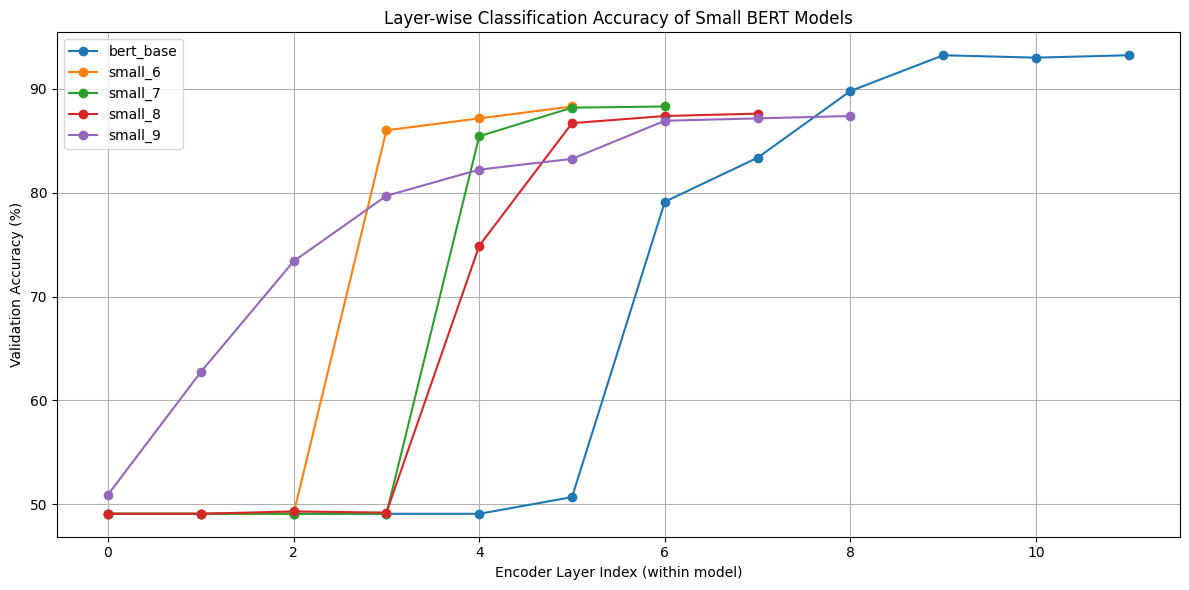

In [39]:
plt.figure(figsize=(12, 6))

for name, accs in model_accuracies_by_layer.items():
    if name == "bert_base":
        accs = accs[1:]  # embedding output 제거
        x = list(range(12))  # 12개의 encoder layer (0~11)
    else:
        x = list(range(len(accs)))  # small model은 그대로

    plt.plot(x, accs, marker='o', label=name)

plt.title("Layer-wise Classification Accuracy of Small BERT Models")
plt.xlabel("Encoder Layer Index (within model)")
plt.ylabel("Validation Accuracy (%)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [40]:
print("\n📊 각 모델의 최고 Validation Accuracy (Top Accuracy per Model):")
for model_name, accs in model_accuracies_by_layer.items():
    max_acc = max(accs)
    max_layer = accs.index(max_acc)
    print(f"{model_name:<12} → 최고 정확도: {max_acc:.2f}% (at layer {max_layer})")


📊 각 모델의 최고 Validation Accuracy (Top Accuracy per Model):
bert_base    → 최고 정확도: 93.23% (at layer 10)
small_6      → 최고 정확도: 88.30% (at layer 5)
small_7      → 최고 정확도: 88.30% (at layer 6)
small_8      → 최고 정확도: 87.61% (at layer 7)
small_9      → 최고 정확도: 87.39% (at layer 8)


In [ ]:
print(h.shape)  # debug 용

torch.Size([1, 10, 768])


In [ ]:
# 정확도 저장 리스트
acc_original = []
acc_small = [0] * total_l  # ✅ small_model의 레이어 수만큼 정확도 저장

for layer in range(1, 13):  # BERT-base: layer 1~12
    correct_orig = 0
    correct_small_by_layer = [0] * total_l  # 각 small layer의 정답 수
    total = 0

    for item in tqdm(val_dataset, desc=f"Layer {layer}"):
        text = item["sentence"]
        label = item["label"]
        inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True).to(device)

        with torch.no_grad():
            # BERT-base layer별 정확도
            outputs = model(**inputs)
            hidden = outputs.hidden_states[layer]
            pooled = model.bert.pooler(hidden)
            pooled_dropped = dropout(pooled)
            logits_orig = model.classifier(pooled_dropped)
            pred_orig = torch.argmax(logits_orig).item()

            # small model: 전체 forward + hidden states
            logits_small, small_hidden_states = small_model(**inputs, output_hidden_states=True)

            for i, h in enumerate(small_hidden_states):
                pooled_small = small_model.pooler(h)  # CLS 포함
                pooled_small = dropout(pooled_small)
                logits = small_model.classifier(pooled_small)
                pred = torch.argmax(logits, dim=-1).item()
                correct_small_by_layer[i] += int(pred == label)

            correct_orig += int(pred_orig == label)
            total += 1

    acc_original.append(correct_orig / total)

    # 마지막 layer 기준에서 정확도 누적 (1 epoch 끝났을 때만 기록됨)
    if layer == 13:
        acc_small = [c / total for c in correct_small_by_layer]

Layer 12: 100%|██████████| 872/872 [00:11<00:00, 76.72it/s]


In [ ]:
acc_small

[0.5,
 0.5561926605504587,
 0.6731651376146789,
 0.8038990825688074,
 0.8153669724770642,
 0.823394495412844,
 0.8669724770642202,
 0.8727064220183486,
 0.8727064220183486]

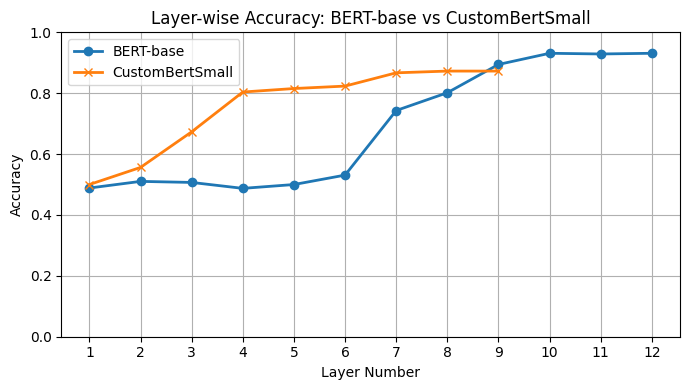

In [ ]:
plt.figure(figsize=(7, 4))
plt.plot(range(1, 13), acc_original, label="BERT-base", marker='o', linewidth=2)
plt.plot(range(1, total_l + 1), acc_small, label="CustomBertSmall", marker='x', linewidth=2)
plt.xlabel("Layer Number")
plt.ylabel("Accuracy")
plt.title("Layer-wise Accuracy: BERT-base vs CustomBertSmall")
plt.legend()
plt.grid(True)
plt.xticks(range(1, 13))
plt.ylim(0, 1.0)
plt.tight_layout()
# plt.savefig(f"img/bert_vs_small_layers_{epoch_num}.png", dpi=300)
plt.show()

In [ ]:
for i, acc in enumerate(acc_small):
    print(f"Layer {i}: {acc:.2f}%")

Layer 0: 0.50%
Layer 1: 0.56%
Layer 2: 0.67%
Layer 3: 0.80%
Layer 4: 0.82%
Layer 5: 0.82%
Layer 6: 0.87%
Layer 7: 0.87%
Layer 8: 0.87%
